# Treść zadania

Zaimplementować bufor jako aktywny obiekt (Producenci-Konsumenci)

Wskazówki:

1. Pracownik powinien implementować samą kolejkę (bufor) oraz dodatkowe metody (czyPusty etc.), które pomogą w
   implementacji strażników. W klasie tej powinna być tylko funkcjonalność, ale nie logika związana z synchronizacją.
2. Dla każdej metody aktywnego obiektu powinna być specjalizacja klasy `MethodRequest`. W tej klasie m.in. zaimplementowana
   jest metoda `guard()`, która oblicza spełnienie warunków synchronizacji (korzystając z metod dostarczonych przez Pracownika).
3. `Proxy` wykonuje się w wątku klienta, który wywołuje metodę. Tworzenie `MethodRequest` i kolejkowanie jej w `ActivationQueue`
   odbywa się również w wątku klienta. `Servant` i `Scheduler` wykonują się w osobnym (oba w tym samym) wątku.

# Rozwiązanie

**Active object** – współbieżny wzorzec projektowy, którego celem jest współbieżne wykonywanie metod obiektu.
We wzorcu oddziela się proces wywołania metody od jej wykonania, które odbywa się we własnym wątku obiektu.
Wywołania metod są kolejkowane i wykonywane sekwencyjnie przez planistę. W międzyczasie, wątek wywołujący metodę
może zająć się wykonywaniem innych czynności w oczekiwaniu na pojawienie się wyniku.

Wzorzec składa się z sześciu elementów:

1. `Servant` – oryginalny obiekt, do którego chcemy zapewnić współbieżny dostęp.
2. `Proxy` – dostępny publicznie interfejs z metodami analogicznymi, jak w oryginalnym obiekcie, które generują
   odpowiednie żądania w imieniu wywołującego je wątku.
3. `Scheduler` – planista kontrolowany przez proxy, w którym wykonuje się własny wątek aktywnego obiektu.
   Planista odbiera żądania, kolejkuje je oraz wykonuje po kolei.
4. `ActivationQueue` – kolejka wywołań metod.
5. `MethodRequest` – interfejs żądania rozszerzony przez konkretne implementacje dla poszczególnych metod aktywnego
   obiektu. Przenosi argumenty wywoływanej metody oraz opisuje sposób jej wywołania.
6. `Future` – obiekt, do którego zapisywany zostanie wynik wykonania metody, zwracany wątkowi wywołującemu.

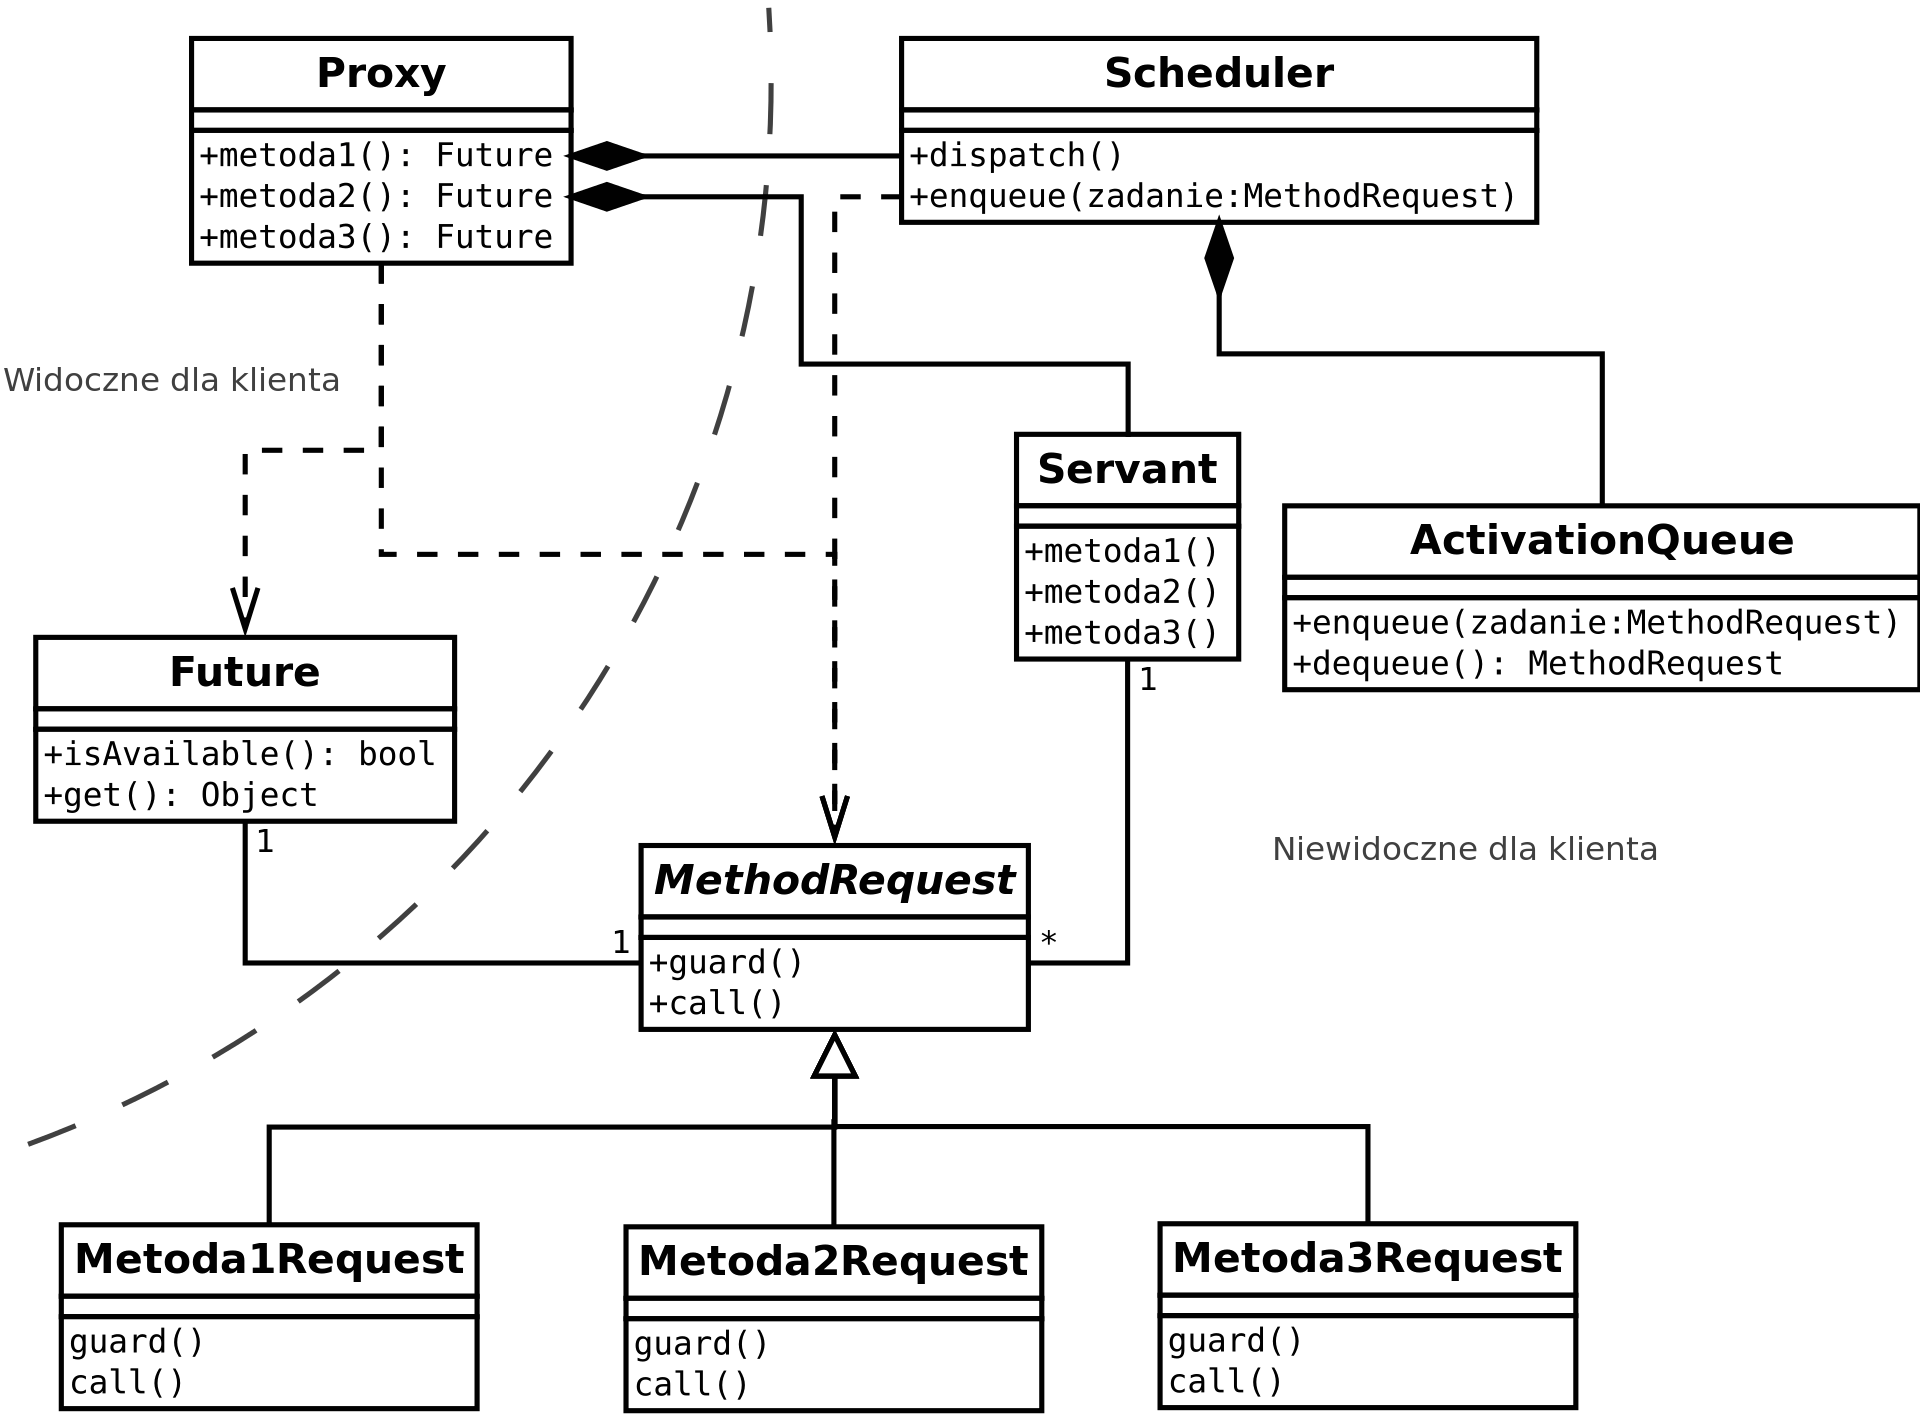

$$ \text{Diagram UML wzorca Active object} $$

W trakcie wykonania tego laboratorium powstała następująca struktura:

```
tw-lab7/src/main/java/pl/edu/agh/tw/knapp/lab7
    activeobject
        buffer
            Buffer.java
            BufferProxy.java
        MethodRequest.java
        MethodRequestQueue.java
        Scheduler.java
        SimpleFuture.java
    demo
        Consumer.java
        Logger.java
        Main.java
        Producer.java
        RandomSleeper.java
        Worker.java
```

Pakiet `activeobject` zawiera implementację współbieżnego wzorcu projectowego *Active Object*, w tym czasie
`demo` zawiera przykładową implementację korzystającą z tego wzorca (problem producenta-konsumenta).

## Active Object

Jak już zostało wspomniane wcześniej, wzorzec *Active Object* składa się z sześciu elementów. Pakiet `activeobject`
zawiera właśnie 6 klas, reprezentujących poszczególne elementy tego wzorca.

### `Buffer<T>`

Jest to klasa, reprezentująca bufor. Zawiera samą funkcjonalność, bez logiki związanej z synchronizacją. We wzorcu
*Active Object* tej klasie odpowiada **Servant**, jest to bowiem obiekt, do którego chcemy zapewnić współbieżny dostęp.

Implementacja wygląda następująco:

```java
// Buffer.java

package pl.edu.agh.tw.knapp.lab7.activeobject.buffer;

import java.util.ArrayList;
import java.util.Collections;
import java.util.List;

public class Buffer<T> {
    private final List<T> buffer;
    private int bufferPos = 0;
    private int bufferActualSize = 0;

    public Buffer(int capacity) {
        buffer = new ArrayList<>(Collections.nCopies(capacity, null));
    }

    public boolean put(T element) {
        if (isFull())
            return false;

        var index = (bufferPos + bufferActualSize) % buffer.size();
        ++bufferActualSize;
        buffer.set(index, element);

        return true;
    }

    public T pop() {
        if (isEmpty())
            return null;

        var result = buffer.get(bufferPos);
        bufferPos = (bufferPos + 1) % buffer.size();
        --bufferActualSize;

        return result;
    }

    public int size() {
        return bufferActualSize;
    }

    public int capacity() {
        return buffer.size();
    }

    public boolean isEmpty() {
        return size() == 0;
    }

    public boolean isNotEmpty() {
        return !isEmpty();
    }

    public boolean isFull() {
        return size() == capacity();
    }

    public boolean isNotFull() {
        return !isFull();
    }
}
```

Jak wynika z implementacji, jest to bufor cykliczny typu FIFO.

### `BufferProxy<T>`

Klasa posiadająca metody o tych samych nazwach i argumentach co i `Buffer`, lecz zwracających `Future<T>` zamiast `T`
(gdzie `T` - typ zwracany przez oryginalne metody klasy `Buffer`). Generuje odpowiednie żądania w imieniu wywołującego
wątku. Jak już wynika z samej nazwy, we wzorcu *Active Object* odpowiednikiem jest **Proxy**.

Implementacja tej klasy jest następująca:

```java
// BufferProxy.java

package pl.edu.agh.tw.knapp.lab7.activeobject.buffer;

import pl.edu.agh.tw.knapp.lab7.activeobject.MethodRequest;
import pl.edu.agh.tw.knapp.lab7.activeobject.Scheduler;

import java.util.concurrent.Future;
import java.util.function.Supplier;

public class BufferProxy<T> {
    private final Buffer<T> buffer;
    private final Scheduler scheduler;

    public BufferProxy(int capacity, Scheduler scheduler) {
        buffer = new Buffer<>(capacity);
        this.scheduler = scheduler;
    }

    public Future<Boolean> put(T element) {
        return scheduler.enqueue(mkMethodRequest(() ->
            buffer.put(element), buffer::isNotFull));
    }

    public Future<T> pop() {
        return scheduler.enqueue(mkMethodRequest(buffer::pop, buffer::isNotEmpty));
    }

    public Future<Integer> size() {
        return scheduler.enqueue(mkMethodRequest(buffer::size, () -> true));
    }

    public Future<Integer> capacity() {
        return scheduler.enqueue(mkMethodRequest(buffer::capacity, () -> true));
    }

    public Future<Boolean> isEmpty() {
        return scheduler.enqueue(mkMethodRequest(buffer::isEmpty, () -> true));
    }

    public Future<Boolean> isNotEmpty() {
        return scheduler.enqueue(mkMethodRequest(buffer::isNotEmpty, () -> true));
    }

    public Future<Boolean> isFull() {
        return scheduler.enqueue(mkMethodRequest(buffer::isFull, () -> true));
    }

    public Future<Boolean> isNotFull() {
        return scheduler.enqueue(mkMethodRequest(buffer::isNotFull, () -> true));
    }

    private static <V> MethodRequest<V> mkMethodRequest(
        Supplier<V> call,
        Supplier<Boolean> guard
    ) {
        return new MethodRequest<>() {
            @Override
            public V call() {
                return call.get();
            }

            @Override
            public boolean guard() {
                return guard.get();
            }
        };
    }
}
```

W celu podniesienia czytelności została utworzona metoda pomocnicza `mkMethodRequest`, przyjmująca jako argumenty
interfejs `call` typu `Supplier<V>`, gdzie `V` - dowolny typ, oraz interfejs `guard` typu `Supplier<Boolean>`
zwracający `true` jeżeli wszystkie warunki zostały spełnione i `call` może zostać wywołany, `false` w przeciwnym
przypadku. Metoda ta zwraca `MethodRequest<V>`.

Innymi słowy,

```java
mkMethodRequest(AKCJA, WARUNEK)
```

### `MethodRequest<T>`

Ten interfejs jest używany do przekazania kontekstu wywołania metody z `Proxy` do `Scheduler`a uruchomionego w osobnym wątku.
Definiuje interfejs dla wykonywania metod Aktywnego Obiektu. Oprócz metody `call`, interfejs ten zawiera również metodę
`guard`, służącą do sprawdzenia, czy warunki związane z synchronizacją są spełnione. Jak sama nazwa wskazuje, we wzorcu
*Active Object* odpowiednikiem jest **MethodRequest**.

Implementacja:

```java
// MethodRequest.java

package pl.edu.agh.tw.knapp.lab7.activeobject;

public interface MethodRequest<T> {
    T call();
    boolean guard();
}
```

### `MethodRequestQueue<T extends MethodRequest<?>>`

Zawiera bufor oczekujących `MethodRequest` utworzonych przez `Proxy`. Jest zasobem dzielonym dla wątków klienta i
pracownika (`Servant`) - pierwszy jest producentem żądań metody, drugi ich konsumentem (przez `Scheduler`).
We wzorcu *Active Object* odpowiednikiem jest **ActivationQueue**.

#### Dostępne metody

- `void put(T element)` - umieszcza element w kolejce
- `void forEachReady(Consumer<? super T> consumer)` - `consumer` zostanie wywołany dla elementów ze spełnionymi
  warunkami synchronizacji (inaczej mówiąc, dla tych obiektów dla których metoda `guard` zwróciła `true`)
- `int currentSize()` - rozmiar aktywnej kolejki
- `int waitSize()` - rozmiar kolejki oczekiwania
- `int size()` - łączny rozmiar w/w kolejek

#### Problem naiwnej implementacji

W przypadku *naiwnej* implementacji, można w łatwy sposób dojść do zagłodzenia niektórych `MethodRequest`.
Wystarczy, że mamy bufor o rozmiarze `1`, do kolejki `MethodRequestQueue` kolejno dodajemy:

```
<put(0)>  # dodaje 0
<put(1)>  # dodanie się nie powiodło: kolejka jest pełna
<pop>     # usuwa 0
<put(2)>  # dodaje 2
```

Po wywołaniu `forEachReady` w kolejce zostanie `<put(1)>`. Jeżeli będziemy wykonywać kolejne 

```
<pop>     # usuwa 2
<put(n)>  # dodaje n
```

to `<put(1)>` nigdy nie zostanie wykonane.

W celu rozwiązania tego problemu, **zostały utworzone 2 osobne kolejki**: `currentQueue` oraz `waitQueue`.

- `currentQueue` zawiera te `MethodRequest`, które trzeba spróbować wykonac przy kolejnym wywołaniu `forEachReady`
- `waitQueue` zawiera te `MethodRequest`, warunki synchronizacji których nie zostały spełnione podczas
  wywołania `forEachReady`

#### Algorytm

1. Dopóki kolejka `currentQueue` nie jest pusta:
   1. Ściągnij element z `currentQueue`
   2. Jeżeli warunki synchronizacji zostały spełnione, wywołaj `consumer.accept(element)`
      - Sprawdź, czy dla którychś elementów z `waitQueue` nie zostały spełnione warunki synchronizacji. Jeżeli tak,
        wywołaj `Consumer::accept` dla tych elementów i usuń z kolejki `waitQueue`
   3. W przeciwnym przypadku dodaj do `waitQueue`
2. Wykonaj `swap(currentQueue, waitQueue)`

#### Implementacja

```java
// MethodRequestQueue.java

package pl.edu.agh.tw.knapp.lab7.activeobject;

import java.util.ArrayDeque;
import java.util.Queue;
import java.util.function.Consumer;

public class MethodRequestQueue<T extends MethodRequest<?>> {
    private Queue<T> waitQueue = new ArrayDeque<>();
    private Queue<T> currentQueue = new ArrayDeque<>();

    public void put(T element) {
        currentQueue.add(element);
    }

    public void forEachReady(Consumer<? super T> consumer) {
        while (!currentQueue.isEmpty()) {
            var element = currentQueue.poll();

            if (element.guard()) {
                consumer.accept(element);

                // try to execute something from the wait queue
                for (int i = 0; i < waitQueue.size(); i++) {
                    var waiting = waitQueue.poll();

                    if (waiting.guard()) {
                        consumer.accept(waiting);
                    } else {
                        waitQueue.add(waiting);
                    }
                }
            } else {
                waitQueue.add(element);
            }
        }

        // swap, currentQueue is empty now,
        // waitQueue may be not empty
        var tmp = waitQueue;
        waitQueue = currentQueue;
        currentQueue = tmp;
    }

    public int currentSize() {
        return currentQueue.size();
    }

    public int waitSize() {
        return waitQueue.size();
    }

    public int size() {
        return currentSize() + waitSize();
    }
}
```

### `Scheduler`

Wykonuje się w osobnym wątku, zarządzając `MethodRequestQueue`. Zawiera odwzorowanie między `MethodRequest<?>`
a `Future<?>`. Jak sama nazwa wskazuje, we wzorcu *Active Object* odpowiednikiem jest **Scheduler**.

Podczas wykonania metody `<T> Future<T> enqueue(MethodRequest<T> methodRequest)` odwzorowanie między
`MethodRequest<?>` a `Future<?>` zostaje aktualizowane: zapamiętujemy, dla którego `MethodRequest` został stworzony
który `Future`, aby później moć przekazać wynik pochodzący z `MethodRequest` do odpowiedniego `Future`.

Implementacja wygląda następująco:

```java
// Scheduler.java

package pl.edu.agh.tw.knapp.lab7.activeobject;

import java.util.HashMap;
import java.util.Map;
import java.util.concurrent.Future;

public class Scheduler extends Thread {
    private final MethodRequestQueue<MethodRequest<?>> methodRequestQueue =
        new MethodRequestQueue<>();

    private final Map<MethodRequest<?>, SimpleFuture<?>> methodRequestFutureMap =
        new HashMap<>();

    private boolean isRunning = true;

    private int autoDispatchMod = 5;

    public void setAutoDispatchMod(int autoDispatchMod) {
        this.autoDispatchMod = autoDispatchMod;
    }

    public int getAutoDispatchMod() {
        return autoDispatchMod;
    }

    public <T> Future<T> enqueue(MethodRequest<T> methodRequest) {
        var future = new SimpleFuture<T>();

        synchronized (this) {
            methodRequestFutureMap.put(methodRequest, future);
            methodRequestQueue.put(methodRequest);

            if (methodRequestQueue.size() % autoDispatchMod == 0) {
                dispatch();
            }
        }

        return future;
    }

    public synchronized void dispatch() {
        notify();
    }

    public synchronized void shutdown() {
        isRunning = false;
        notify();
    }

    @Override
    public synchronized void run() {
        while (isRunning) {
            try {
                wait();
            } catch (InterruptedException e) {
                throw new RuntimeException(e);
            }

            methodRequestQueue.forEachReady(methodRequest ->
                methodRequestFutureMap.remove(methodRequest).put(methodRequest.call()));
        }
    }
}
```

### `SimpleFuture<T>`

Implementuje interfejs `Future<T>`. Pozwala klientowi pobranie wyniku wykonania metody, gdy `Servant` zakończy jej
wykonanie. Po wywołaniu metody w `Proxy`, obiekt `Future` jest od razu zwracany. `Future` rezerwuje miejsce na wyniki
wywołania metody. Gdy klient chce te wyniki pobrać, albo się blokuje do czasu pojawienia się wyników, albo periodycznie
sprawdza przez *polling*. We wzorcu *Active Object* odpowiednikiem jest **Future**.

Implementacja:

```java
// SimpleFuture.java

package pl.edu.agh.tw.knapp.lab7.activeobject;

import org.jetbrains.annotations.NotNull;

import java.util.concurrent.CountDownLatch;
import java.util.concurrent.Future;
import java.util.concurrent.TimeUnit;
import java.util.concurrent.TimeoutException;

public final class SimpleFuture<T> implements Future<T> {
    private final CountDownLatch latch = new CountDownLatch(1);
    private T value;

    @Override
    public boolean cancel(boolean mayInterruptIfRunning) {
        return false;
    }

    @Override
    public boolean isCancelled() {
        return false;
    }

    @Override
    public boolean isDone() {
        return latch.getCount() == 0;
    }

    @Override
    public T get() throws InterruptedException {
        latch.await();
        return value;
    }

    @Override
    public T get(
        long timeout,
        @NotNull TimeUnit unit
    ) throws InterruptedException, TimeoutException {
        if (latch.await(timeout, unit)) {
            return value;
        } else {
            throw new TimeoutException();
        }
    }

    // Calling this more than once doesn't make sense, and won't
    // work properly in this implementation. so: don't.
    // Visibility: package private
    void put(Object result) {
        value = (T) result;
        latch.countDown();
    }
}
```

## Demo

**Problem producenta i konsumenta** – klasyczny informatyczny problem synchronizacji. W problemie występują dwa
rodzaje procesów: producent i konsument, którzy dzielą wspólny zasób – bufor – dla produkowanych (i konsumowanych)
jednostek. Zadaniem producenta jest wytworzenie produktu, umieszczenie go w buforze i rozpoczęcie pracy od nowa.
W tym samym czasie konsument ma pobrać produkt z bufora. Problemem jest taka synchronizacja procesów, żeby producent
nie dodawał nowych jednostek gdy bufor jest pełny, a konsument nie pobierał gdy bufor jest pusty.

Ten problem został rozwiązany za pomocą wzorcu współbieżności **Active Object**:

- Producent we własnym wątku produkuje dane i zapisuje je do bufora za pośrednictwem `BufferProxy`
- Konsument we własnym wątku odczytuje dane z bufora za pośrednictwem `BufferProxy`

Implementacja zostanie omówiona poniżej.

### `Worker<T>`

Klasa abstrakcyjna, nadrzędna klasa producenta i konsumenta. Zawiera abstrakcyjną metodę
`boolean onIter(int iteration)`, która jest wywoływana co każdą iterację. Jeżeli zwróci `false`,
iterowanie zostanie przerwane.

```java
// Worker.java

package pl.edu.agh.tw.knapp.lab7.demo;

import pl.edu.agh.tw.knapp.lab7.activeobject.buffer.BufferProxy;

public abstract class Worker<T> extends Thread {
    private final static Logger logger = Logger.getInstance();

    private final RandomSleeper randomSleeper;
    private final int iterCount;

    protected final int timeoutMs;
    protected final BufferProxy<T> bufferProxy;

    public Worker(
        int delayMinMs, int delayMaxMs,
        int timeoutMs, int iterCount,
        BufferProxy<T> bufferProxy)
    {
        this.randomSleeper = new RandomSleeper(delayMinMs, delayMaxMs);
        this.timeoutMs = timeoutMs;
        this.iterCount = iterCount;
        this.bufferProxy = bufferProxy;
    }

    @Override
    public void run() {
        for (int i = 0; i < iterCount; i++) {
            if (!onIter(i))
                break;

            try {
                randomSleeper.sleep();
            } catch (InterruptedException e) {
                throw new RuntimeException(e);
            }
        }

        log("Done");
    }

    protected abstract boolean onIter(int iteration);

    protected void log(Object o) {
        logger.log(
            String.format("%s (tid %s)", getClass().getSimpleName(), getId()), o);
    }
}
```

### `Producer`

Producent. Dziedziczy po `Worker<Integer>`, a więc produkuje wartości typu `Integer`.

```java
// Producer.java

package pl.edu.agh.tw.knapp.lab7.demo;

import pl.edu.agh.tw.knapp.lab7.activeobject.buffer.BufferProxy;

import java.util.concurrent.ExecutionException;
import java.util.concurrent.TimeUnit;
import java.util.concurrent.TimeoutException;
import java.util.concurrent.atomic.AtomicInteger;

public class Producer extends Worker<Integer> {
    private final static AtomicInteger counter = new AtomicInteger();

    public Producer(
        int delayMinMs, int delayMaxMs,
        int timeoutMs, int iterCount,
        BufferProxy<Integer> bufferProxy)
    {
        super(delayMinMs, delayMaxMs, timeoutMs, iterCount, bufferProxy);
    }

    @Override
    protected boolean onIter(int iteration) {
        var value = counter.getAndIncrement();

        try {
            log("Putting " + value);

            boolean result =
                bufferProxy.put(value).get(timeoutMs, TimeUnit.MILLISECONDS);

            if (!result) {
                log("put has failed");
            } else {
                log("Putted " + value);
            }

            return result;
        } catch (InterruptedException | ExecutionException e) {
            throw new RuntimeException(e);
        } catch (TimeoutException e) {
            log("put timed out, value=" + value);
            return false;
        }
    }
}
```

Z implementacji wynika, że:

- Wszystkie producenty współdzielą ten sam licznik (`AtomicInteger counter`), wartości którego są zapisywane do bufora
- Po wykonaniu żądania na zapis do bufora, producent będzie czekał na wynik, ale nie dłużej niż `timeoutMs`
  - W przypadku przekroczenia tego czasu, iterowanie zostanie przerwane z odpowiednim komunikatem
  - W przypadku niepowodzenia, iterowanie zostanie przerwane z odpowiednim komunikatem

### `Consumer`

Konsument. Dziedziczy po `Worker<Integer>`, a więc odczytuje z bufora wartości typu `Integer`.

```java
// Consumer.java

package pl.edu.agh.tw.knapp.lab7.demo;

import pl.edu.agh.tw.knapp.lab7.activeobject.buffer.BufferProxy;

import java.util.concurrent.ExecutionException;
import java.util.concurrent.TimeUnit;
import java.util.concurrent.TimeoutException;

public class Consumer extends Worker<Integer> {
    public Consumer(
        int delayMinMs, int delayMaxMs,
        int timeoutMs, int iterCount,
        BufferProxy<Integer> bufferProxy)
    {
        super(delayMinMs, delayMaxMs, timeoutMs, iterCount, bufferProxy);
    }

    @Override
    protected boolean onIter(int iteration) {
        try {
            var element = bufferProxy.pop().get(timeoutMs, TimeUnit.MILLISECONDS);
            log("Popped: " + element);
            return true;
        } catch (InterruptedException | ExecutionException e) {
            throw new RuntimeException(e);
        } catch (TimeoutException e) {
            log("pop timed out, iteration=" + iteration);
            return false;
        }
    }
}
```

Z implementacji wynika, że:

- Konsument próbuje pobrać wartość z bufora w ciągu `timeoutMs` milisekund
- Jeżeli ten czas zostanie przekroczony, iterowanie zostanie przerwane z odpowiednim komunikatem
- W przeciwnym przypadku zostanie wypisany pobrany element

### `Main`

Jest to **klasa główna** tej aplikacji. Tworzy oraz uruchamia wątki producentów i konsumentów.

Akceptuje następującą **listę parametrów**:

1. Minimalny czas opóźnienia, w milisekundach
2. Maksymalny czas opóźnienia, w milisekundach
3. Maksymalny czas zapisu/odczytu do/z bufora, w milisekundach
4. Liczba iteracji
5. Liczba producentów
6. Liczba konsumentów
7. Pojemność bufora

W przypadku gdy żadne argumenty nie zostaną przekazane, zostaną użyte *wartości domyślne*.

```java
// Main.java

package pl.edu.agh.tw.knapp.lab7.demo;

import pl.edu.agh.tw.knapp.lab7.activeobject.Scheduler;
import pl.edu.agh.tw.knapp.lab7.activeobject.buffer.BufferProxy;

import java.util.List;
import java.util.stream.Stream;

public class Main {
    private record Params(
            int delayMinMs,
            int delayMaxMs,
            int timeoutMs,
            int iterCount,
            int producerCount,
            int consumerCount,
            int bufferCapacity
    ) {}

    /**
     * The application's entry point
     * @param args The arguments list:<br>
     *             args[0]: The minimum delay, ms, `int`<br>
     *             args[1]: The maximum delay, ms, `int`<br>
     *             args[2]: The wait timeout, ms, `int`<br>
     *             args[3]: The number of iterations, `int`<br>
     *             args[4]: The number of producers, `int`<br>
     *             args[5]: The number of consumers, `int`<br>
     *             args[6]: The buffer capacity, `int`<br>
     */
    public static void main(String[] args) throws InterruptedException {
        var params = new Params(0, 0, 1000, 100, 10, 10, 100);

        if (args.length != 0) {
            if (args.length != 7)
                throw new IllegalArgumentException(
                    "expected 7 arguments, got " + args.length);

            params = new Params(
                    Integer.parseInt(args[0]),
                    Integer.parseInt(args[1]),
                    Integer.parseInt(args[2]),
                    Integer.parseInt(args[3]),
                    Integer.parseInt(args[4]),
                    Integer.parseInt(args[5]),
                    Integer.parseInt(args[6]));
        }

        var scheduler = new Scheduler();
        scheduler.setAutoDispatchMod(1);
        scheduler.start();

        var buffer = new BufferProxy<Integer>(params.bufferCapacity, scheduler);

        demo(params, buffer);

        scheduler.dispatch();
        scheduler.shutdown();
        scheduler.join();
    }

    private static void demo(
        Params p,
        BufferProxy<Integer> bufferProxy
    ) throws InterruptedException {
        var producers = Stream.generate(() -> mkProducer(p, bufferProxy))
                .limit(p.producerCount)
                .toList();

        var consumers = Stream.generate(() -> mkConsumer(p, bufferProxy))
                .limit(p.consumerCount)
                .toList();

        producers.forEach(Thread::start);
        consumers.forEach(Thread::start);

        joinAll(producers);
        joinAll(consumers);
    }

    private static Producer mkProducer(Params p, BufferProxy<Integer> bufferProxy) {
        return new Producer(
            p.delayMinMs, p.delayMaxMs, p.timeoutMs, p.iterCount, bufferProxy);
    }

    private static Consumer mkConsumer(Params p, BufferProxy<Integer> bufferProxy) {
        return new Consumer(
            p.delayMinMs, p.delayMaxMs, p.timeoutMs, p.iterCount, bufferProxy);
    }

    private static void joinAll(List<? extends Thread> threads)
        throws InterruptedException
    {
        for (var thread : threads) {
            thread.join();
        }
    }
}
```

Aplikacja może zostać uruchomiona korzystając z następującego polecenia:

```bash
./gradlew run
```

lub, w przypadku jeżeli chcemy podać argumenty, to np.:

```bash
./gradlew run --args="0 0 1000 100 10 10 100"
```

# Wyniki

Wyniki zostały pobrane korzystając z domyślnych parametrów, tzn. aplikacja została uruchomiona poleceniem

```bash
./gradlew run --args="0 0 1000 100 10 10 100"
```

Po wykonaniu tego polecenia na standardowe wyjście zostało wypisane następujące:

```
[Producer (tid 28)] Putting 5
[Producer (tid 25)] Putting 2
[Producer (tid 31)] Putting 8
[Producer (tid 24)] Putting 1
[Producer (tid 26)] Putting 3
[Producer (tid 23)] Putting 0
[Producer (tid 30)] Putting 7
[Producer (tid 27)] Putting 4
[Producer (tid 29)] Putting 6
[Producer (tid 32)] Putting 9
[Producer (tid 27)] Putted 4
[Producer (tid 24)] Putted 1
[Producer (tid 24)] Putting 11
[Producer (tid 26)] Putted 3
...
[Consumer (tid 36)] Popped: 0
[Consumer (tid 33)] Popped: 4
[Producer (tid 30)] Putted 16
[Producer (tid 31)] Putted 8
[Producer (tid 29)] Putted 6
[Producer (tid 31)] Putting 24
[Consumer (tid 33)] Popped: 12
[Producer (tid 29)] Putting 25
[Producer (tid 27)] Putted 10
[Producer (tid 30)] Putting 23
[Consumer (tid 36)] Popped: 11
...
[Producer (tid 28)] Putted 994
[Consumer (tid 42)] Popped: 994
[Producer (tid 28)] Putting 995
[Producer (tid 28)] Putted 995
[Producer (tid 28)] Putting 996
[Consumer (tid 35)] Popped: 995
[Producer (tid 28)] Putted 996
[Consumer (tid 42)] Popped: 996
[Producer (tid 28)] Putting 997
[Consumer (tid 42)] Done
[Producer (tid 28)] Putted 997
[Consumer (tid 35)] Popped: 997
[Producer (tid 28)] Putting 998
[Producer (tid 28)] Putted 998
[Producer (tid 28)] Putting 999
[Consumer (tid 35)] Popped: 998
[Producer (tid 28)] Putted 999
[Producer (tid 28)] Done
[Consumer (tid 35)] Popped: 999
[Consumer (tid 35)] Done
```

Widzimy tu komunikaty sygnalizujące o tym, że producent zaczął umieszczać pewną wartość w buforze (`Putting`),
że ją umieścił (`Putted`) i że konsument tę wartość odczytał (`Popped`). Również zostały wypisane komunikaty
`Done`, mówiące o tym, że wątek zakończył działanie.

Warto zauważyć, że w niektórych przpadkach możemy zaobserwować najpierw komunikat `Popped N` a dopiero potem `Putted N`.
Czyli zgodnie z wypisanymi wynikami może się wydawać, że wartość zostaje pobrana jeszcze do tego jak została zapisana
do bufora. Oczywiście że to nie jest i nie może być prawdą, i wynika to z tego, że wątek producenta może zostać obudzony
później, niż wątek konsumenta. A więc w takim przypadku zobaczymy najpierw komunikat pochodzący od konsumenta, a dopiero
potem od producenta.

# Wnioski

- **Aktywny obiekt** (ang. **Active Object**) oddziela wykonanie metody od wywołania metody aby poprawić współbieżność
  i uprościć synchronizowany dostęp do obiektów, które są umieszczone w swoich własnych wątkach

- Wzorzec Active Object składa się z **sześciu** składników:
  
  1. `Servant`
  2. `Proxy`
  3. `Scheduler`
  4. `ActivationQueue`
  5. `MethodRequest`
  6. `Future`

  `Servant` to obiekt, do którego `Proxy` zapewnia dostęp. `Proxy` generuje żądania, które są obsługiwane przez `Scheduler`.
  Żądania są umieszczane w `ActivationQueue` i reprezentowane przez `MethodRequest`. Wynik jest zapisywany do `Future`.

- **W celu uniknięcia** potencjalnego **zagłodzenia** niektórych żądań, musimy stosować odpowiednie mechanizmy

- **Problem producenta-konsumenta** został rozwiązany korzystając ze wzorca Active Object:
  - Producent we własnym wątku produkuje dane i zapisuje je do bufora za pośrednictwem `BufferProxy`
  - Konsument we własnym wątku odczytuje dane z bufora za pośrednictwem `BufferProxy`

# Bibliografia

1. Materiały do laboratorium, dr inż. Włodzimierz Funika:\
   [https://home.agh.edu.pl/~funika/tw/lab7/](https://home.agh.edu.pl/~funika/tw/lab7/)

2. Active Object, Wikipedia:\
   [https://pl.wikipedia.org/wiki/Active_object](https://pl.wikipedia.org/wiki/Active_object)\
   [https://en.wikipedia.org/wiki/Active_object](https://en.wikipedia.org/wiki/Active_object)

3. Problem producenta i konsumenta, Wikipedia:\
   [https://pl.wikipedia.org/wiki/Problem_producenta_i_konsumenta](https://pl.wikipedia.org/wiki/Problem_producenta_i_konsumenta)

4. `SimpleFuture`, Klaus Brunner:\
   [https://gist.github.com/KlausBrunner/4110226](https://gist.github.com/KlausBrunner/4110226)

5. `Supplier`, Java 17 Docs:\
   [https://docs.oracle.com/en/java/javase/17/docs/api/java.base/java/util/function/Supplier.html](https://docs.oracle.com/en/java/javase/17/docs/api/java.base/java/util/function/Supplier.html)